P2

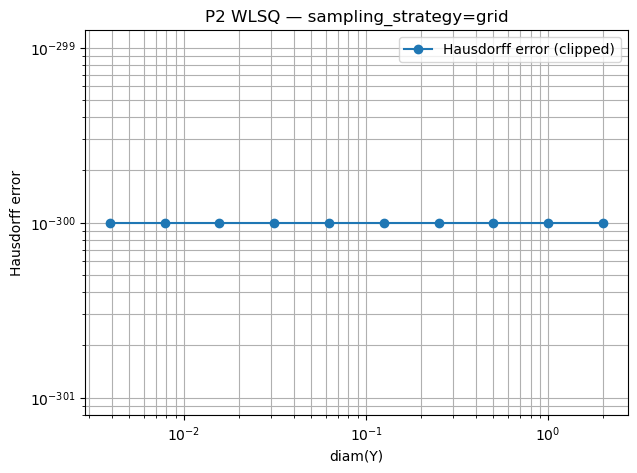

Not enough positive error points to fit a slope (errors may be 0).
Estimated beta = nan


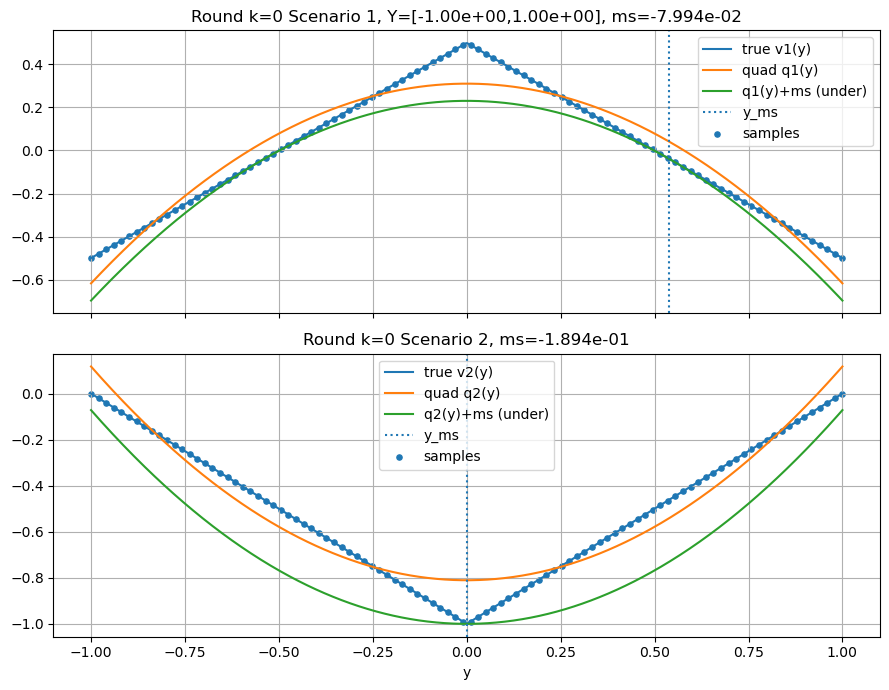

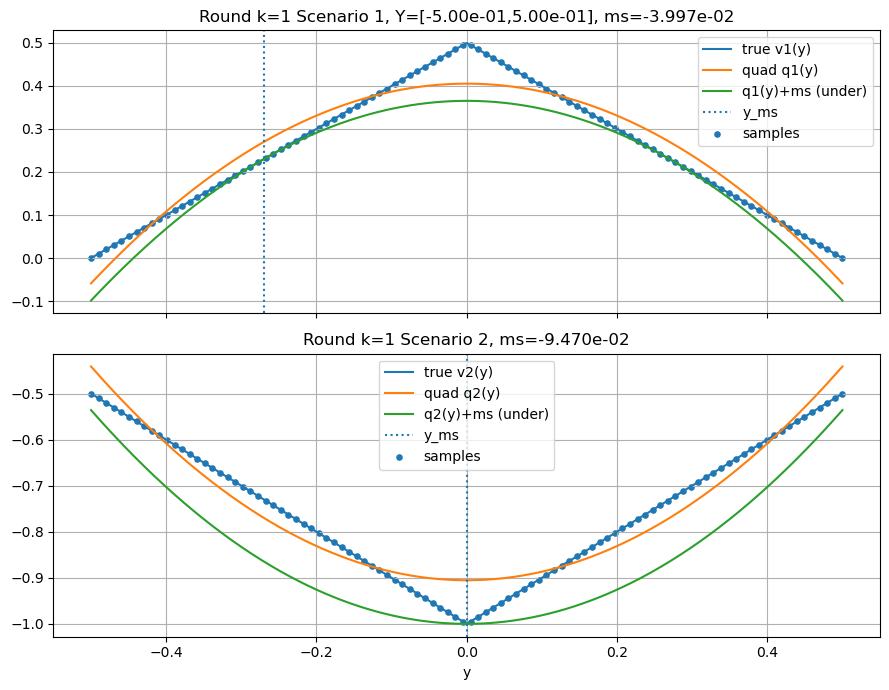

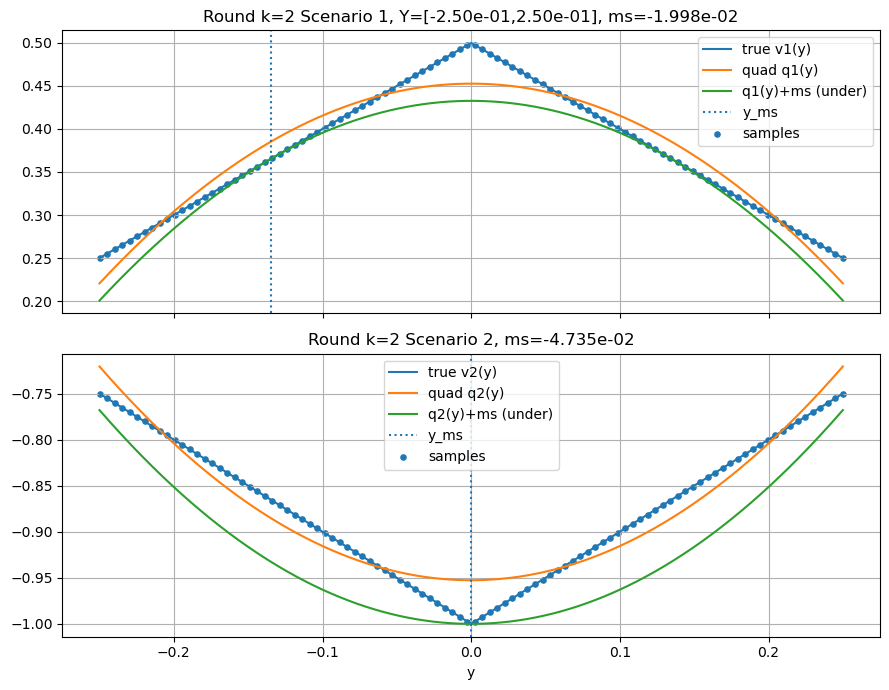

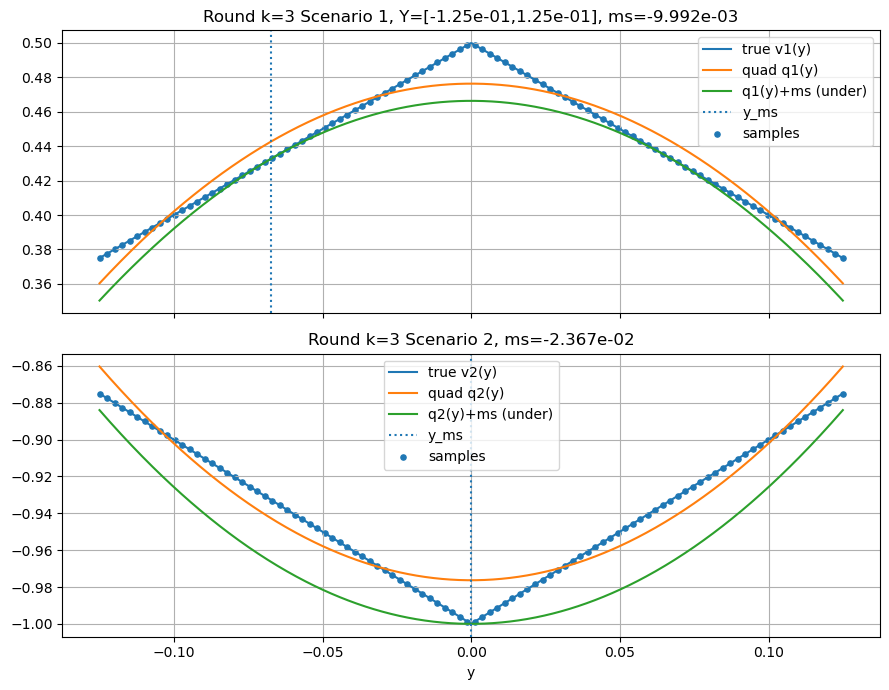

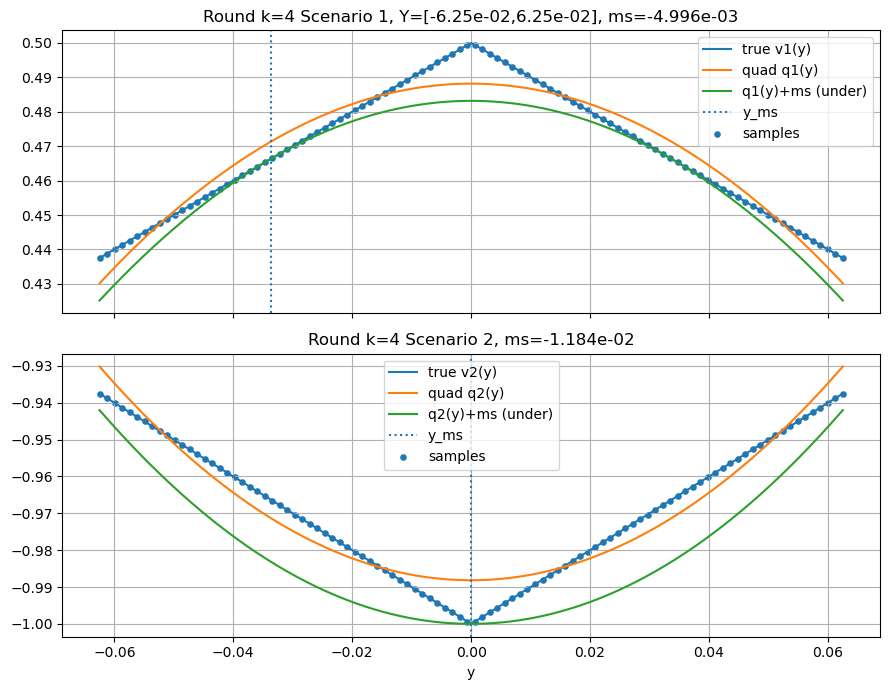

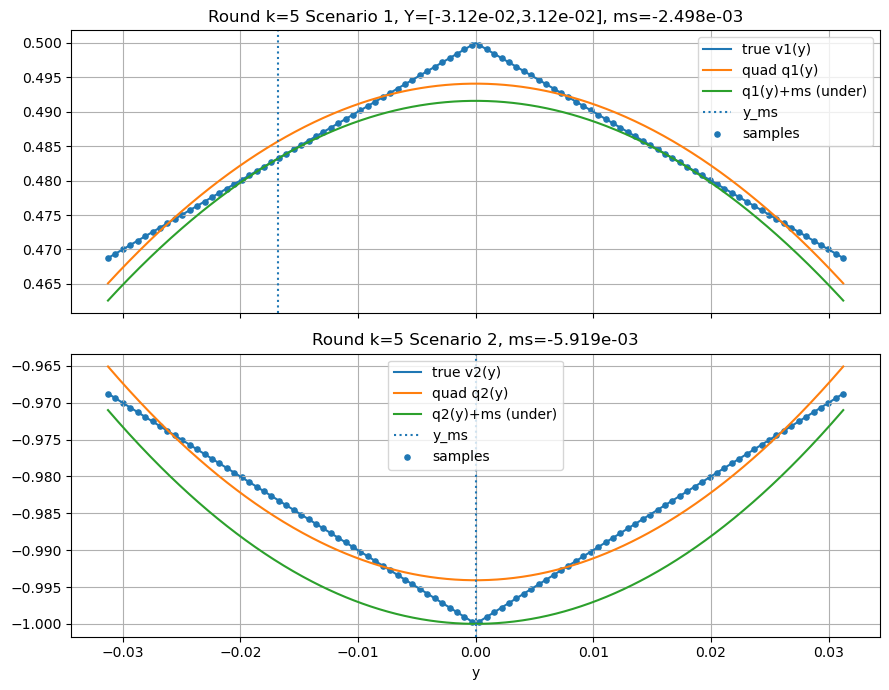

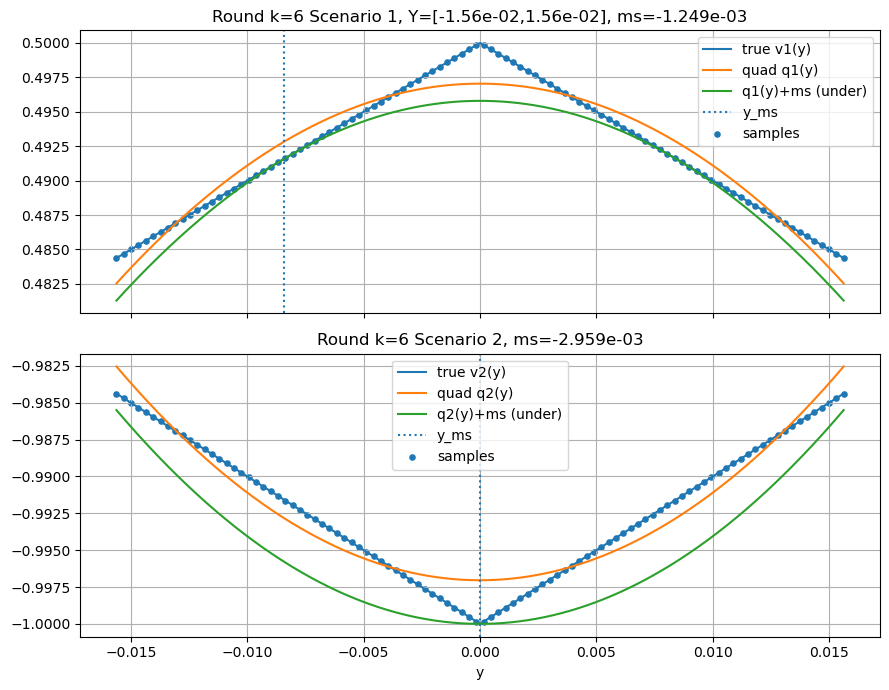

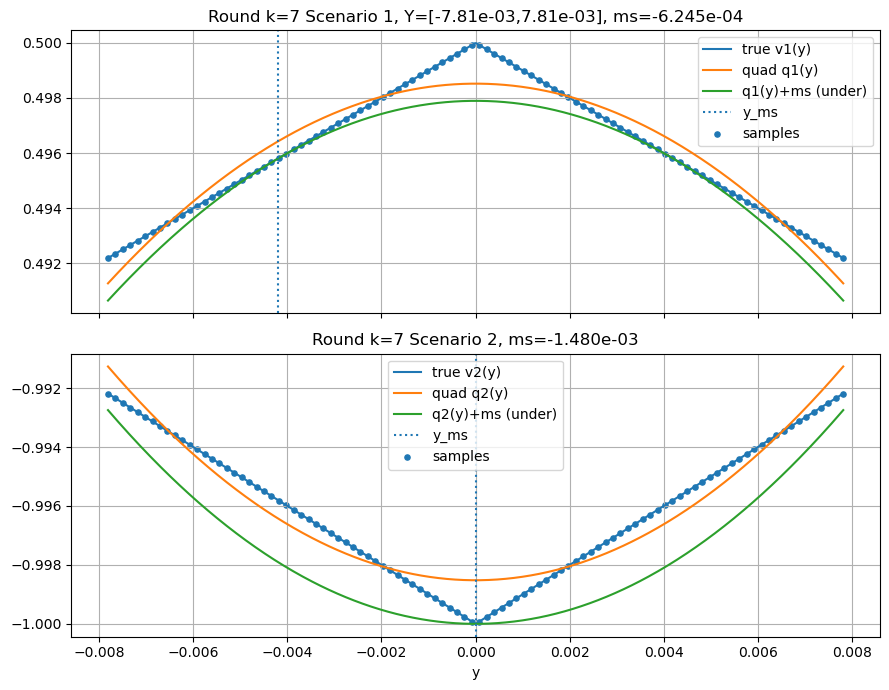

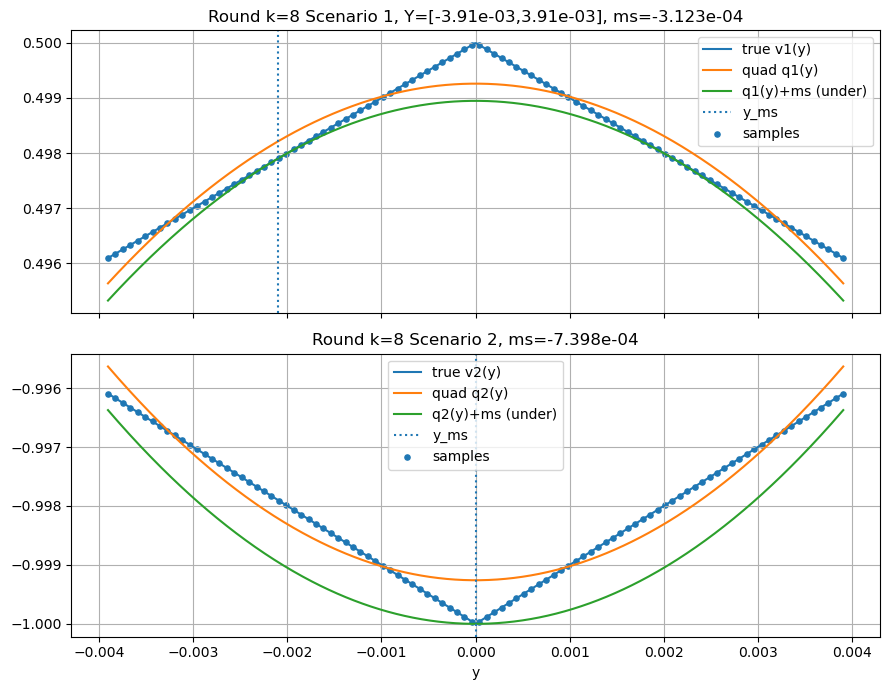

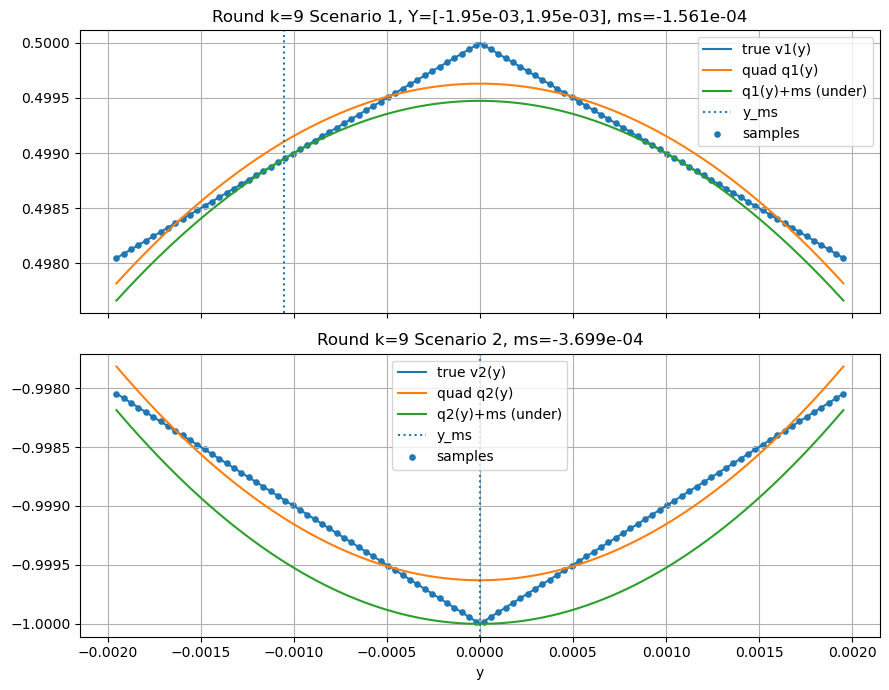

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Dict

# ============================================================
# P2: scenario value functions (paper)
# v1(y) = -|y| + 0.5
# v2(y) =  |y| - 1.0
# weights P1=P2=0.5
# total true f(y) = -0.5 (constant)
# ============================================================
def v1(y: float) -> float:
    return -abs(y) + 0.5

def v2(y: float) -> float:
    return  abs(y) - 1.0

P1 = 0.5
P2 = 0.5

def f_true(y: float) -> float:
    return P1*v1(y) + P2*v2(y)  # constant -0.5

TRUE_MIN_P2 = -0.5  # min_{y in Y} f_true(y)

# ============================================================
# Models
# ============================================================
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float       # shift so that q+ms <= v on Y
    y_ms: float     # argmax of (q - v) over Y

    def q(self, y):
        y = np.asarray(y, dtype=float)
        return self.a*y*y + self.b*y + self.c

    def under(self, y):
        return self.q(y) + self.ms

@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray
    y_ms: float
    ms: float

# ============================================================
# Weighted least squares fit: q(y)=a y^2 + b y + c
# ============================================================
def fit_weighted_quadratic(ys: np.ndarray, fs: np.ndarray, w: np.ndarray):
    ys = np.asarray(ys, dtype=float).ravel()
    fs = np.asarray(fs, dtype=float).ravel()
    w  = np.asarray(w,  dtype=float).ravel()
    assert ys.shape == fs.shape == w.shape

    X = np.vstack([ys**2, ys, np.ones_like(ys)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = fs * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a,b,c = coef.tolist()
    return a,b,c

# ============================================================
# Robust shift (grid global search + local refine)
# ms = - max_{y in Y} (q(y) - v(y))
# ============================================================
def robust_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float,float],
    grid_n: int = 6001,
    refine_iters: int = 40
):
    lo, hi = Y
    ys = np.linspace(lo, hi, grid_n)
    qv = a*ys*ys + b*ys + c
    vv = np.array([v(float(t)) for t in ys])
    h  = qv - vv  # want max

    idx = int(np.argmax(h))
    y0  = float(ys[idx])
    best_val = float(h[idx])

    # local refine in a tiny bracket around the best grid point
    L = float(ys[max(idx-1, 0)])
    U = float(ys[min(idx+1, grid_n-1)])
    if U - L > 1e-15:
        def h_scalar(t: float) -> float:
            return (a*t*t + b*t + c) - v(t)

        l, r = L, U
        for _ in range(refine_iters):
            m1 = l + (r-l)/3.0
            m2 = r - (r-l)/3.0
            if h_scalar(m1) < h_scalar(m2):
                l = m1
            else:
                r = m2
        y_ref = 0.5*(l+r)
        val_ref = h_scalar(y_ref)
        if val_ref > best_val:
            best_val = float(val_ref)
            y0 = float(y_ref)

    ms = -best_val
    return float(ms), float(y0)

# ============================================================
# Sampling strategies
# 1) random
# 2) grid
# 3) grid_low_weight (weights emphasize low fs)
# 4) grid_then_ms_nearby (add 30 points near preliminary ms)
# ============================================================
def make_samples(
    sampling_strategy: str,
    v: Callable[[float], float],
    Y: Tuple[float,float],
    n_samples: int,
    rng: np.random.Generator,
    extra_ms_points: int = 30,
    ms_radius_frac: float = 0.10,  # radius = frac*(hi-lo)
):
    lo, hi = Y

    if sampling_strategy == "random":
        ys = rng.uniform(lo, hi, size=n_samples)

    elif sampling_strategy in ("grid", "grid_low_weight", "grid_then_ms_nearby"):
        ys = np.linspace(lo, hi, n_samples)

    else:
        raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")

    ys = np.unique(ys)
    fs = np.array([v(float(t)) for t in ys])

    if sampling_strategy == "grid_then_ms_nearby":
        # preliminary fit on grid with uniform weights
        w0 = np.ones_like(fs)
        a0,b0,c0 = fit_weighted_quadratic(ys, fs, w0)
        ms0, y_ms0 = robust_shift_to_underestimator(v, a0,b0,c0, Y)

        radius = max(ms_radius_frac*(hi-lo), 1e-12)
        L = max(lo, y_ms0 - radius)
        U = min(hi, y_ms0 + radius)
        ys_extra = rng.uniform(L, U, size=extra_ms_points)

        ys = np.unique(np.concatenate([ys, ys_extra]))
        fs = np.array([v(float(t)) for t in ys])

    return ys, fs

def make_weights(sampling_strategy: str, ys: np.ndarray, fs: np.ndarray, alpha: float = 5.0):
    if sampling_strategy in ("random", "grid", "grid_then_ms_nearby"):
        return np.ones_like(fs)

    if sampling_strategy == "grid_low_weight":
        # larger weight for lower values
        fmin = float(np.min(fs))
        return np.exp(-alpha*(fs - fmin))

    raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")

# ============================================================
# Build WLSQ underestimator for one scenario on interval Y
# ============================================================
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float,float],
    n_samples: int,
    rng: np.random.Generator,
    sampling_strategy: str,
    extra_ms_points: int = 30,
):
    ys, fs = make_samples(sampling_strategy, v, Y, n_samples, rng, extra_ms_points=extra_ms_points)
    w = make_weights(sampling_strategy, ys, fs)

    a,b,c = fit_weighted_quadratic(ys, fs, w)
    ms, y_ms = robust_shift_to_underestimator(v, a,b,c, Y)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag  = FitDiag(ys=ys, fs=fs, w=w, y_ms=y_ms, ms=ms)
    return model, diag

# ============================================================
# Min of quadratic on interval
# ============================================================
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b/(2*a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))

# ============================================================
# Hausdorff error for P2 on interval Y:
# err(Y) = | min_Y f_true - min_Y f_relax |
# Here min_Y f_true = -0.5.
# Relaxation is an underestimator => min_Y f_relax <= -0.5,
# so err = (-0.5) - lb.
# ============================================================
def hausdorff_error_for_interval(Y: Tuple[float,float], m1: QuadModel, m2: QuadModel):
    lo, hi = Y
    a = P1*m1.a + P2*m2.a
    b = P1*m1.b + P2*m2.b
    c = P1*(m1.c + m1.ms) + P2*(m2.c + m2.ms)
    lb = min_of_quadratic_on_interval(a,b,c,lo,hi)
    err = TRUE_MIN_P2 - lb
    return lb, err

# ============================================================
# Run experiment: nested intervals Y_k=[-eps_k, eps_k]
# ============================================================
def run_p2_experiment(
    sampling_strategy: str,
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 10,
    n_samples: int = 100,
    extra_ms_points: int = 30,
    seed: int = 1,
):
    rng = np.random.default_rng(seed)

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0*(rho**k)
        Y = (-eps, eps)  # P2 domain is [-1,1], eps0<=1 recommended

        m1, d1 = build_wlsq_underestimator(v1, Y, n_samples, rng, sampling_strategy, extra_ms_points)
        m2, d2 = build_wlsq_underestimator(v2, Y, n_samples, rng, sampling_strategy, extra_ms_points)

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0*eps)
        lb_list.append(lb)
        err_list.append(err)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2))

    return {
        "sampling_strategy": sampling_strategy,
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "rounds": rounds,
        "seed": seed,
        "n_samples": n_samples,
        "extra_ms_points": extra_ms_points
    }

def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # allow zeros; just filter strictly positive before taking logs
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    if x.size < 2:
        return float("nan")  # not enough points to fit

    beta, _ = np.polyfit(np.log(x), np.log(y), 1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 6):
    diam = np.asarray(out["diam"], dtype=float)
    err  = np.asarray(out["err"], dtype=float)

    # Always plot (even if err has zeros)
    plt.figure(figsize=(7,5))
    plt.loglog(diam, np.maximum(err, 1e-300), marker="o", linestyle="-", label="Hausdorff error (clipped)")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    plt.title(f"P2 WLSQ — sampling_strategy={out['sampling_strategy']}")
    plt.legend()
    plt.show()

    # Fit slope only on positive errors
    mask = (diam > 0) & (err > 0)
    d2 = diam[mask]
    e2 = err[mask]

    if d2.size < 2:
        print("Not enough positive error points to fit a slope (errors may be 0).")
        return float("nan")

    K = min(slope_fit_last, d2.size)
    beta = estimate_slope_loglog(d2[-K:], e2[-K:])
    print(f"Fitted beta on last {K} positive points: {beta:.6f}")
    return beta


def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 600, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    m1, m2 = round_info["m1"], round_info["m2"]
    d1, d2 = round_info["d1"], round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2,1,sharex=True,figsize=(9,7))

    # Scenario 1
    ax = axes[0]
    ax.plot(ys, [v1(float(t)) for t in ys], label="true v1(y)")
    ax.plot(ys, m1.q(ys), label="quad q1(y)")
    ax.plot(ys, m1.under(ys), label="q1(y)+ms (under)")
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=14, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 1, Y=[{lo:.2e},{hi:.2e}], ms={m1.ms:.3e}")
    ax.legend()

    # Scenario 2
    ax = axes[1]
    ax.plot(ys, [v2(float(t)) for t in ys], label="true v2(y)")
    ax.plot(ys, m2.q(ys), label="quad q2(y)")
    ax.plot(ys, m2.under(ys), label="q2(y)+ms (under)")
    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=14, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 2, ms={m2.ms:.3e}")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()

# ============================================================
# RUN ONE STRATEGY (switch here)
# ============================================================
sampling_strategy = "grid"
# sampling_strategy = "random"
# sampling_strategy = "grid_low_weight"
# sampling_strategy = "grid_then_ms_nearby"

params = dict(
    sampling_strategy=sampling_strategy,
    eps0=1.0,       # <=1 for P2 domain [-1,1]
    rho=0.5,
    n_levels=10,
    n_samples=100,
    extra_ms_points=30,  # only used in strategy 4
    seed=1,
)

out = run_p2_experiment(**params)

beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)

for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=700, show_samples=True)


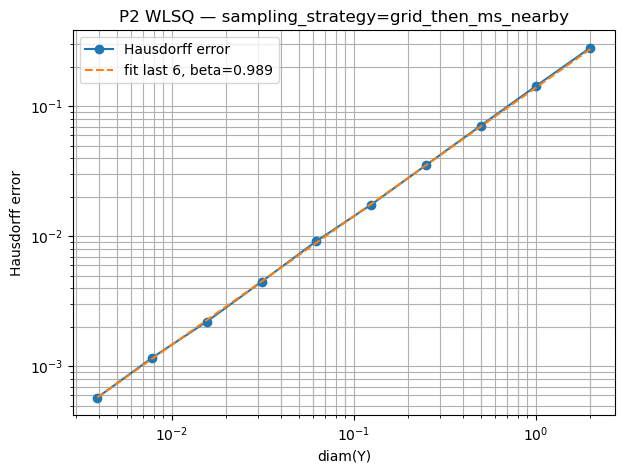

Estimated beta = 0.9894437541437275
Repo sizes: {'P2_s1': 10, 'P2_s2': 10}


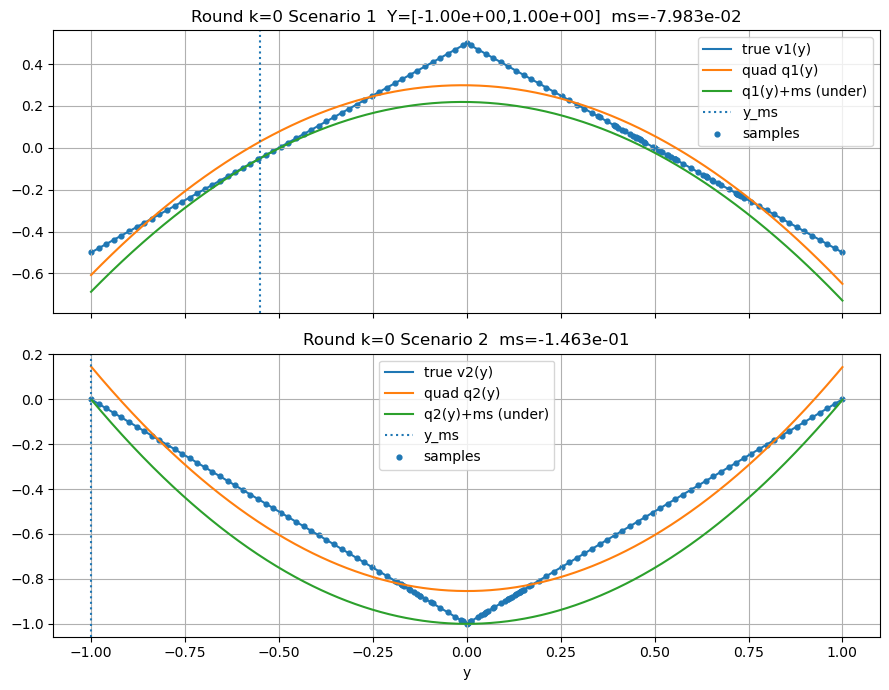

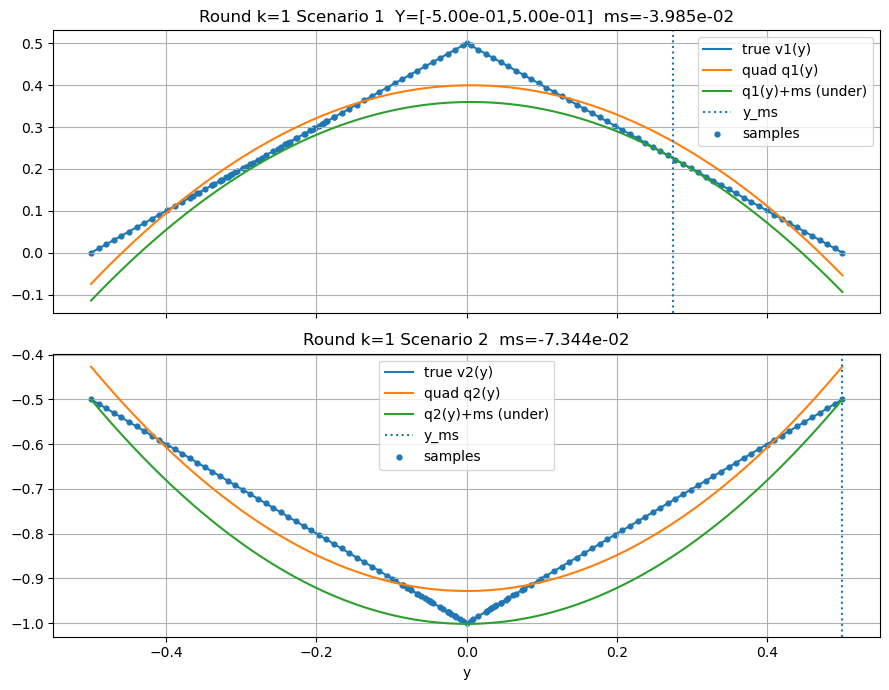

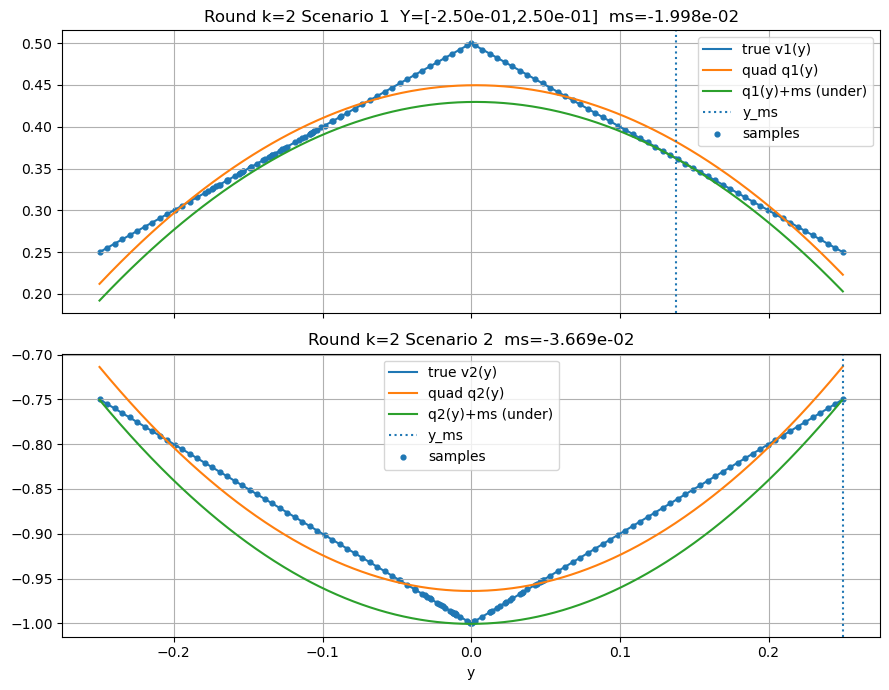

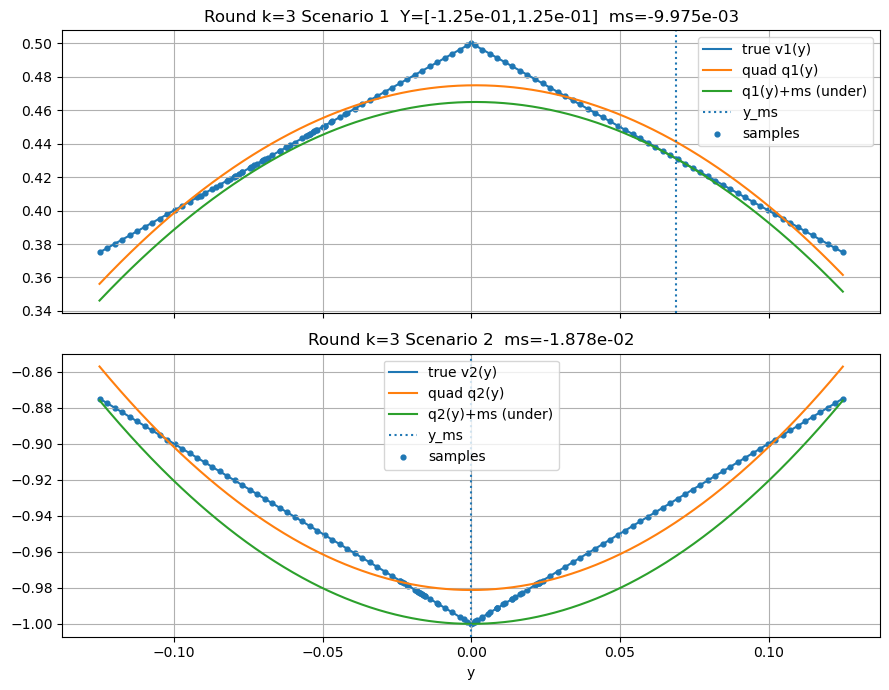

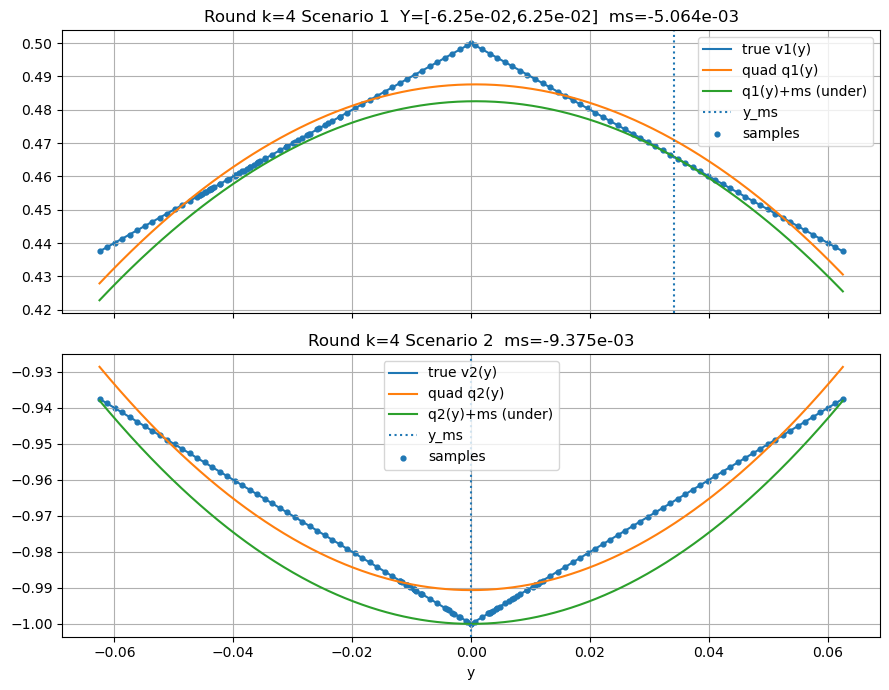

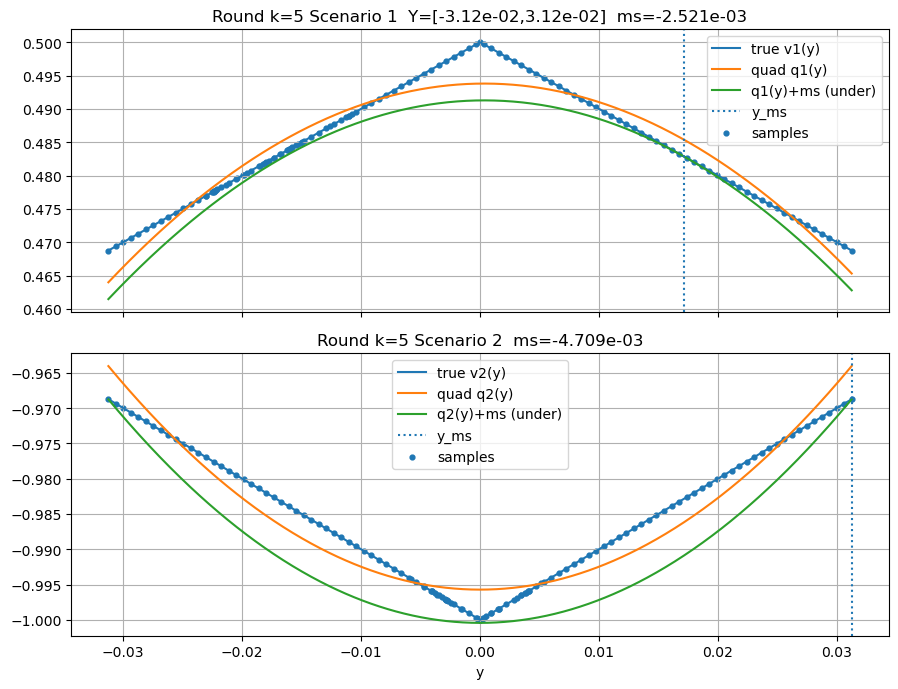

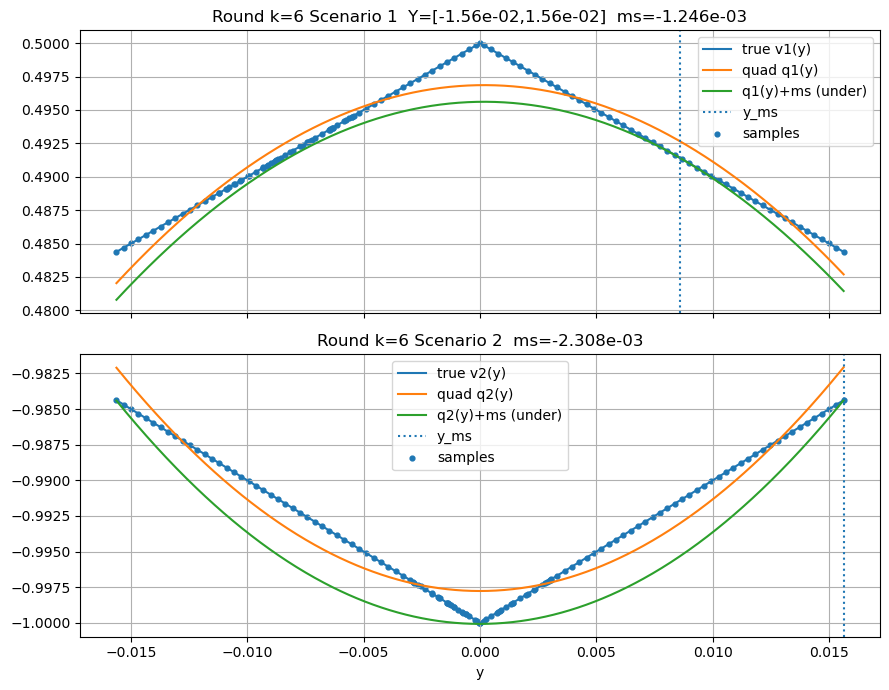

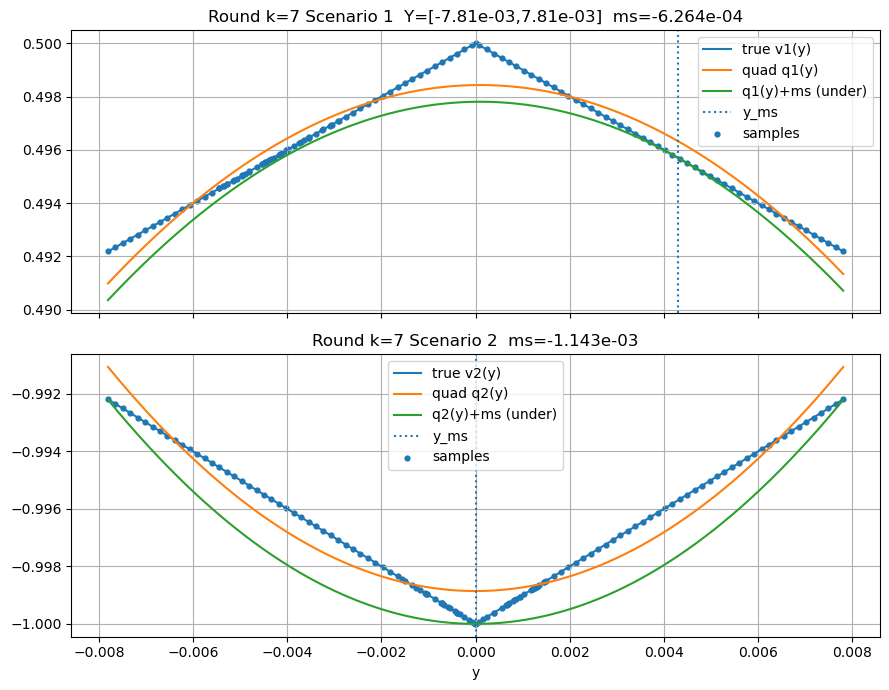

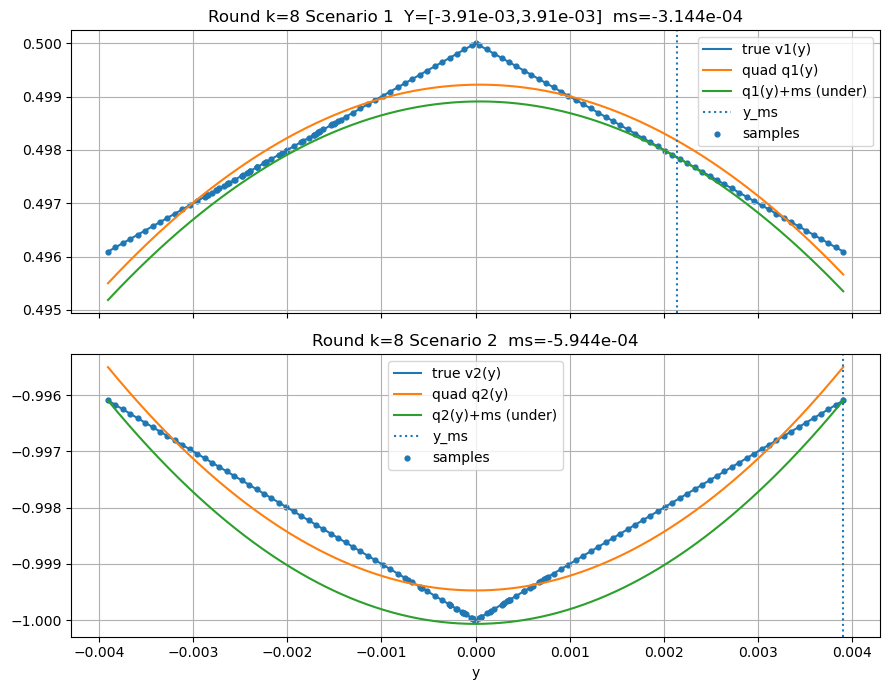

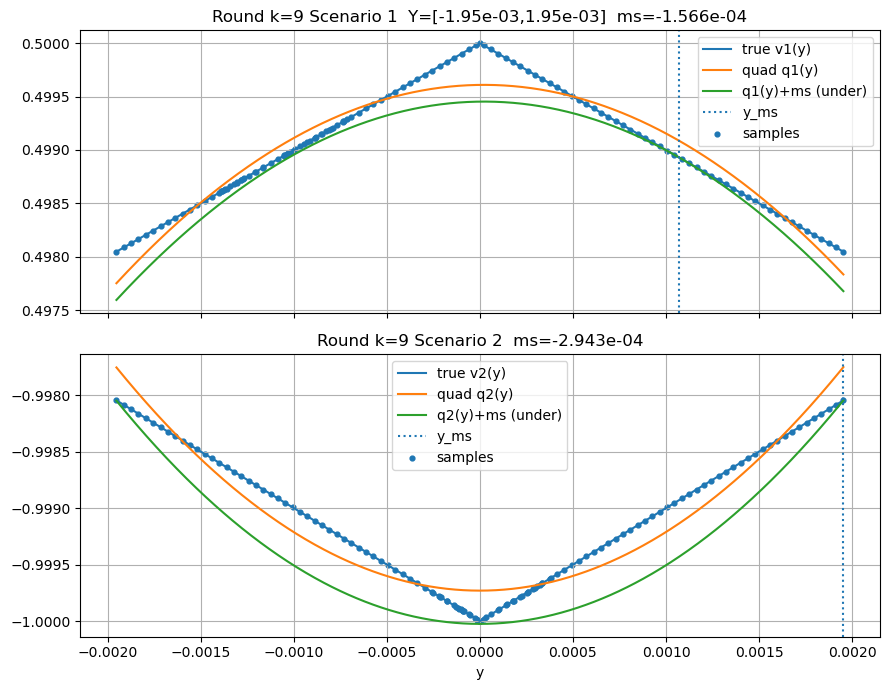

In [5]:
# ============================================================
# P2 (Lipschitz but nonsmooth) + WLSQ + Hausdorff error order
# New version: matches your "working" ms-shift logic (bounded + safety grid)
# + Sampling strategies switch:
#   1) random
#   2) grid
#   3) grid_low_weight
#   4) grid_then_ms_nearby (100 + 30 points)
# + Per-iteration plots:
#   for each k, two subplots (scenario 1 and 2): true / q / q+ms + samples + y_ms
# + Final log-log convergence plot
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, Tuple, Dict, List, Optional
from scipy.optimize import minimize_scalar


# -------------------------
# P2 value functions (paper)
# v1(y) = -|y| + 1/2, v2(y) = |y| - 1, total v(y) = v1+v2 = -1/2
# -------------------------
def v1(y: float) -> float:
    return -abs(y) + 0.5

def v2(y: float) -> float:
    return abs(y) - 1.0

def v_total(y: float) -> float:
    return v1(y) + v2(y)  # == -0.5

TRUE_MIN = -0.5
YSTAR = 0.0

# IMPORTANT: total = sum (weights 1,1) — consistent with your working code
P1 = 1.0
P2 = 1.0


# -------------------------
# MS point repository
# -------------------------
@dataclass
class MSPointRepo:
    points: Dict[str, List[float]] = field(default_factory=dict)
    tol: float = 1e-10

    def add(self, key: str, y: float):
        lst = self.points.setdefault(key, [])
        for yy in lst:
            if abs(yy - y) <= self.tol:
                return
        lst.append(float(y))

    def get_in_interval(self, key: str, Y: Tuple[float, float]) -> np.ndarray:
        lo, hi = Y
        lst = self.points.get(key, [])
        if not lst:
            return np.array([], dtype=float)
        arr = np.array(lst, dtype=float)
        return arr[(arr >= lo) & (arr <= hi)]


# -------------------------
# Quadratic model + diagnostics
# -------------------------
@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float
    y_ms: float

    def q(self, y):
        y = np.asarray(y, dtype=float)
        return self.a*y*y + self.b*y + self.c

    def under(self, y):
        return self.q(y) + self.ms


@dataclass
class FitDiag:
    ys: np.ndarray
    fs: np.ndarray
    w: np.ndarray


# -------------------------
# Weighted LS fit: q(y)=a y^2 + b y + c
# -------------------------
def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    y = np.asarray(y, dtype=float).ravel()
    f = np.asarray(f, dtype=float).ravel()
    w = np.asarray(w, dtype=float).ravel()
    assert y.shape == f.shape == w.shape

    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


# -------------------------
# Exact shift to make underestimator on Y (split at 0 due to nonsmoothness)
# ms = min_{y in Y}(v(y)-q(y)) => q+ms <= v on Y
# plus safety correction by dense grid (avoid tiny violation)
# -------------------------
def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
    safety_grid: int = 5000,
    safety_tol: float = 1e-12,
) -> Tuple[float, float]:
    lo, hi = Y
    assert lo <= 0 <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    # candidates
    cand = [lo, 0.0, hi]
    best_val = -np.inf
    best_y = 0.0
    for y in cand:
        val = h(y)
        if val > best_val:
            best_val = float(val)
            best_y = float(y)

    # bounded search on both sides
    for (L, U) in [(lo, 0.0), (0.0, hi)]:
        if U - L <= 0:
            continue
        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            val = h(res.x)
            if val > best_val:
                best_val = float(val)
                best_y = float(res.x)

    ms = -best_val
    y_ms = best_y

    # safety correction (dense grid)
    ys = np.linspace(lo, hi, safety_grid)
    vv = np.array([v(float(t)) for t in ys])
    viol = np.max((a*ys*ys + b*ys + c + ms) - vv)
    if viol > safety_tol:
        ms -= (viol + safety_tol)

    # refresh y_ms using grid (optional but stable)
    hs = (a*ys*ys + b*ys + c) - vv
    y_ms = float(ys[int(np.argmax(hs))])

    return float(ms), float(y_ms)


# ============================================================
# Sampling strategies (your request)
# ============================================================
def make_samples(
    sampling_strategy: str,
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    extra_ms_points: int = 30,          # for strategy 4
    ms_radius_frac: float = 0.10,       # for strategy 4
) -> np.ndarray:
    lo, hi = Y

    if sampling_strategy == "random":
        ys = rng.uniform(lo, hi, size=n_samples)

    elif sampling_strategy in ("grid", "grid_low_weight", "grid_then_ms_nearby"):
        ys = np.linspace(lo, hi, n_samples)

    else:
        raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")

    ys = np.unique(ys)

    # strategy 4: grid -> one fit -> get ms point -> add 30 random near ms
    if sampling_strategy == "grid_then_ms_nearby":
        fs0 = np.array([v(float(t)) for t in ys])
        w0 = np.ones_like(fs0)
        a0, b0, c0 = fit_weighted_quadratic(ys, fs0, w0)
        ms0, y_ms0 = exact_shift_to_underestimator(v, a0, b0, c0, Y)

        radius = max(ms_radius_frac * (hi - lo), 1e-12)
        L = max(lo, y_ms0 - radius)
        U = min(hi, y_ms0 + radius)
        ys_extra = rng.uniform(L, U, size=extra_ms_points)

        ys = np.unique(np.concatenate([ys, ys_extra]))

    return ys


def make_weights(
    sampling_strategy: str,
    ys: np.ndarray,
    fs: np.ndarray,
    alpha: float = 5.0
) -> np.ndarray:
    if sampling_strategy in ("random", "grid", "grid_then_ms_nearby"):
        return np.ones_like(fs)

    if sampling_strategy == "grid_low_weight":
        fmin = float(np.min(fs))
        return np.exp(-alpha * (fs - fmin))

    raise ValueError(f"Unknown sampling_strategy={sampling_strategy}")


# -------------------------
# Build WLSQ underestimator (with optional ms-repo augmentation)
# -------------------------
def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    sampling_strategy: str,
    ms_repo: Optional[MSPointRepo] = None,
    scenario_key: Optional[str] = None,
    use_msrepo: bool = True,
    extra_ms_points: int = 30,     # for strategy 4
) -> Tuple[QuadModel, FitDiag]:
    lo, hi = Y

    # base samples from strategy
    ys = make_samples(
        sampling_strategy=sampling_strategy,
        v=v, Y=Y, n_samples=n_samples, rng=rng,
        extra_ms_points=extra_ms_points
    )

    # ensure endpoints & 0 exist (stability, matches your P4/P2 style)
    ys = np.unique(np.concatenate([ys, np.array([lo, 0.0, hi])]))

    # add ms-repo points (extra, beyond n_samples)
    if use_msrepo and (ms_repo is not None) and (scenario_key is not None):
        extra = ms_repo.get_in_interval(scenario_key, Y)
        if extra.size > 0:
            ys = np.unique(np.concatenate([ys, extra]))

    fs = np.array([v(float(t)) for t in ys])
    w = make_weights(sampling_strategy, ys, fs)

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms, y_ms = exact_shift_to_underestimator(v, a, b, c, Y)

    if (ms_repo is not None) and (scenario_key is not None):
        ms_repo.add(scenario_key, y_ms)

    model = QuadModel(a=a, b=b, c=c, ms=ms, y_ms=y_ms)
    diag = FitDiag(ys=ys, fs=fs, w=w)
    return model, diag


# -------------------------
# Min of quadratic on [lo,hi]
# -------------------------
def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))


# -------------------------
# Hausdorff error on Y:
# err(Y) = min_Y v_total(y) - min_Y vhat_total(y)
# Here true_min == -0.5 (constant).
# -------------------------
def hausdorff_error_for_interval(Y: Tuple[float, float], m1: QuadModel, m2: QuadModel) -> Tuple[float, float]:
    lo, hi = Y
    a = P1*m1.a + P2*m2.a
    b = P1*m1.b + P2*m2.b
    c = P1*(m1.c + m1.ms) + P2*(m2.c + m2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    err = TRUE_MIN - lb
    return lb, err


# -------------------------
# Run experiment + store per-iteration info
# -------------------------
def run_p2_experiment(
    sampling_strategy: str = "grid",
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 10,
    n_samples: int = 100,
    seed: int = 1,
    use_msrepo: bool = True,
    extra_ms_points: int = 30,  # only used in strategy 4
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)
    ms_repo = MSPointRepo()

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (YSTAR - eps, YSTAR + eps)

        m1, d1 = build_wlsq_underestimator(
            v1, Y, n_samples=n_samples, rng=rng,
            sampling_strategy=sampling_strategy,
            ms_repo=ms_repo, scenario_key="P2_s1",
            use_msrepo=use_msrepo,
            extra_ms_points=extra_ms_points
        )
        m2, d2 = build_wlsq_underestimator(
            v2, Y, n_samples=n_samples, rng=rng,
            sampling_strategy=sampling_strategy,
            ms_repo=ms_repo, scenario_key="P2_s2",
            use_msrepo=use_msrepo,
            extra_ms_points=extra_ms_points
        )

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

        rounds.append(dict(k=k, Y=Y, m1=m1, m2=m2, d1=d1, d2=d2, lb=lb, err=err))

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
        "ms_repo": ms_repo,
        "rounds": rounds,
        "sampling_strategy": sampling_strategy,
        "seed": seed,
        "n_samples": n_samples,
        "use_msrepo": use_msrepo,
    }


def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    if x.size < 2:
        raise RuntimeError("Not enough positive error points to fit slope (need at least 2).")
    beta, _ = np.polyfit(np.log(x), np.log(y), deg=1)
    return float(beta)


def plot_convergence(out: Dict[str, object], slope_fit_last: int = 6) -> float:
    diam = out["diam"]
    err = out["err"]

    mask = (diam > 0) & (err > 0)
    d2 = diam[mask]
    e2 = err[mask]

    if d2.size < 2:
        print("All errors are <= 0 (or numerically 0); cannot fit slope.")
        print("Try different sampling_strategy or reduce safety_grid tolerance.")
        plt.figure()
        plt.plot(diam, err, marker="o")
        plt.title("P2 error (linear scale) — errors not positive")
        plt.xlabel("diam(Y)")
        plt.ylabel("Hausdorff error")
        plt.grid(True)
        plt.show()
        return float("nan")

    K = min(slope_fit_last, d2.size)
    beta = estimate_slope_loglog(d2[-K:], e2[-K:])

    lx = np.log(d2[-K:])
    ly = np.log(e2[-K:])
    c = float(np.mean(ly - beta * lx))
    fit_err = np.exp(beta * np.log(d2) + c)

    plt.figure(figsize=(7,5))
    plt.loglog(d2, e2, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(d2, fit_err, linestyle="--", label=f"fit last {K}, beta={beta:.3f}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    plt.title(f"P2 WLSQ — sampling_strategy={out['sampling_strategy']}")
    plt.legend()
    plt.show()
    return beta


def plot_round_scenarios(round_info: Dict[str, object], n_grid: int = 800, show_samples: bool = True):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    m1: QuadModel = round_info["m1"]
    m2: QuadModel = round_info["m2"]
    d1: FitDiag = round_info["d1"]
    d2: FitDiag = round_info["d2"]

    ys = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

    ax = axes[0]
    ax.plot(ys, np.array([v1(float(t)) for t in ys]), label="true v1(y)")
    ax.plot(ys, m1.q(ys), label="quad q1(y)")
    ax.plot(ys, m1.under(ys), label="q1(y)+ms (under)")
    ax.axvline(m1.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d1.ys, d1.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 1  Y=[{lo:.2e},{hi:.2e}]  ms={m1.ms:.3e}")
    ax.legend()

    ax = axes[1]
    ax.plot(ys, np.array([v2(float(t)) for t in ys]), label="true v2(y)")
    ax.plot(ys, m2.q(ys), label="quad q2(y)")
    ax.plot(ys, m2.under(ys), label="q2(y)+ms (under)")
    ax.axvline(m2.y_ms, linestyle=":", label="y_ms")
    if show_samples:
        ax.scatter(d2.ys, d2.fs, s=12, label="samples")
    ax.grid(True)
    ax.set_title(f"Round k={k} Scenario 2  ms={m2.ms:.3e}")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()


# ============================================================
# RUN (switch sampling_strategy here)
# ============================================================
sampling_strategy = "grid_then_ms_nearby"
# sampling_strategy = "random"
# sampling_strategy = "grid_low_weight"
# sampling_strategy = "grid_then_ms_nearby"

params = dict(
    sampling_strategy=sampling_strategy,
    eps0=1.0,
    rho=0.5,
    n_levels=10,
    n_samples=100,         # default 100
    seed=1,
    use_msrepo=True,       # matches your working style
    extra_ms_points=30,    # only affects strategy 4
)

out = run_p2_experiment(**params)

beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)
print("Repo sizes:", {k: len(v) for k, v in out["ms_repo"].points.items()})

for r in out["rounds"]:
    plot_round_scenarios(r, n_grid=800, show_samples=True)


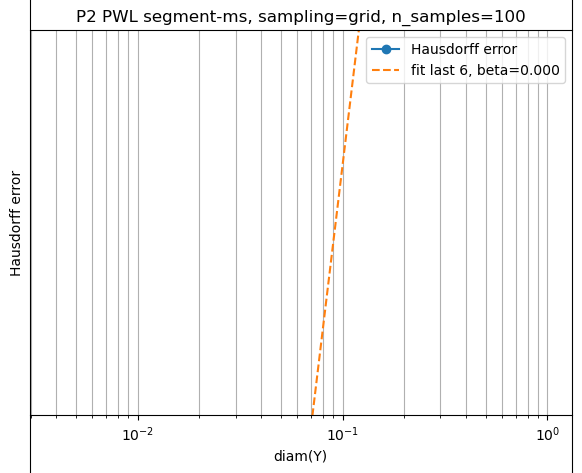

Estimated beta = 1.4533432577151741e-15


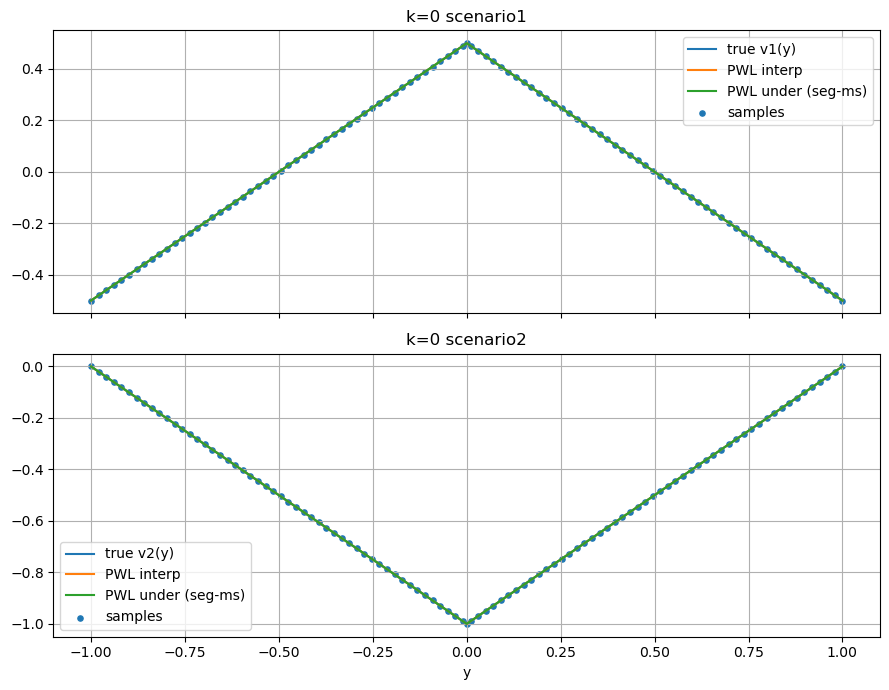

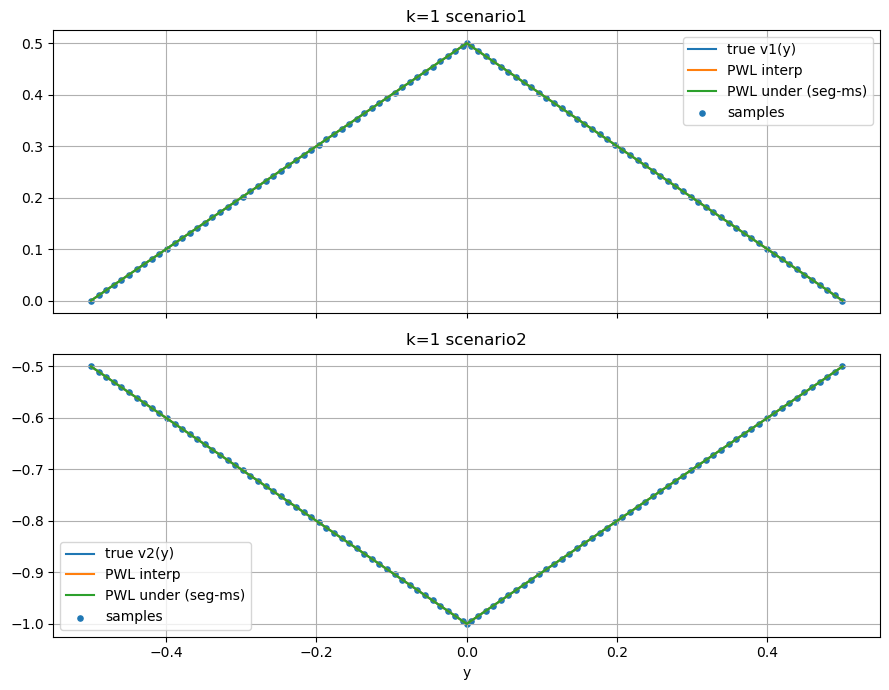

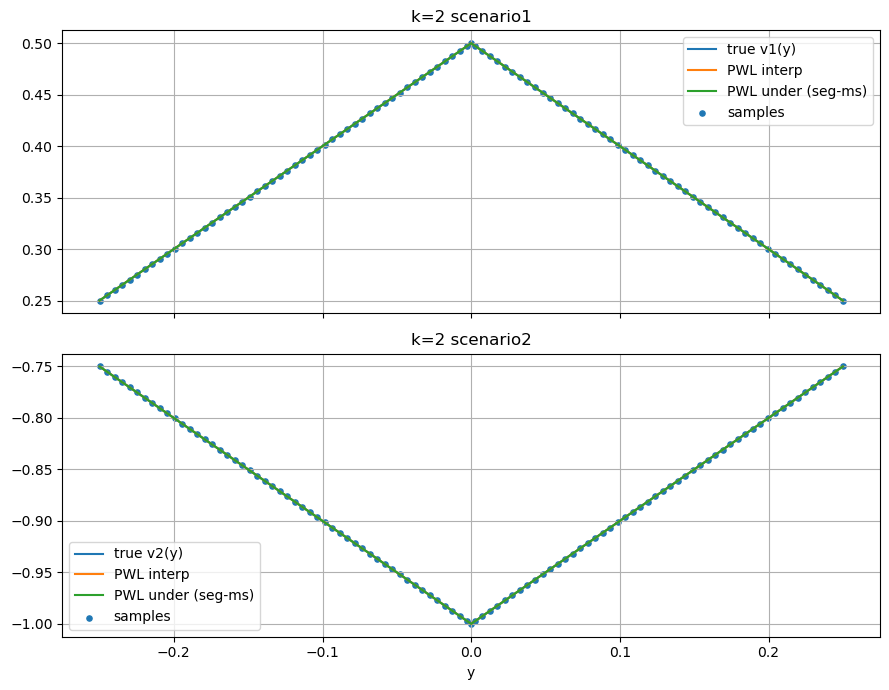

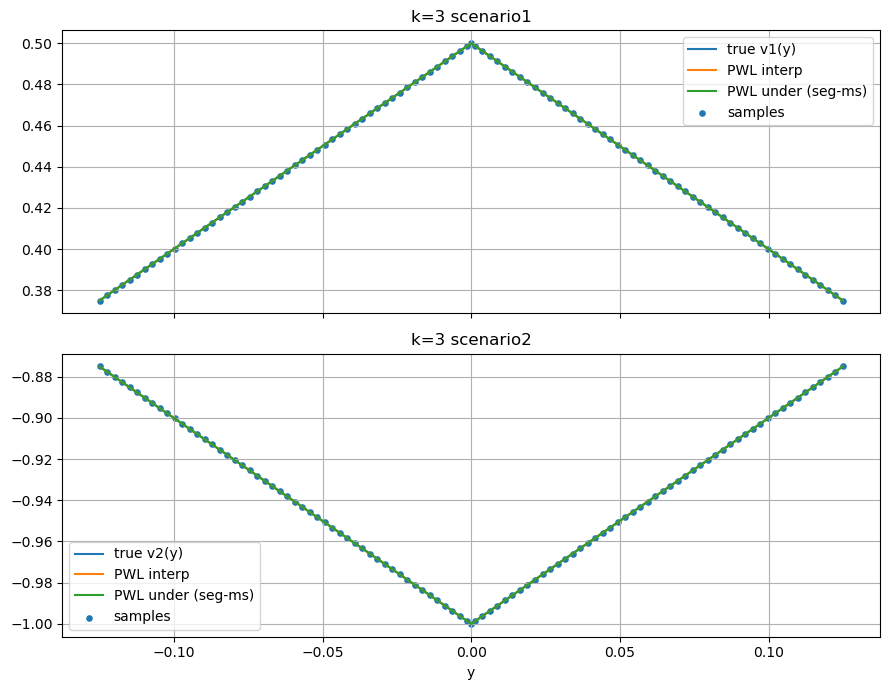

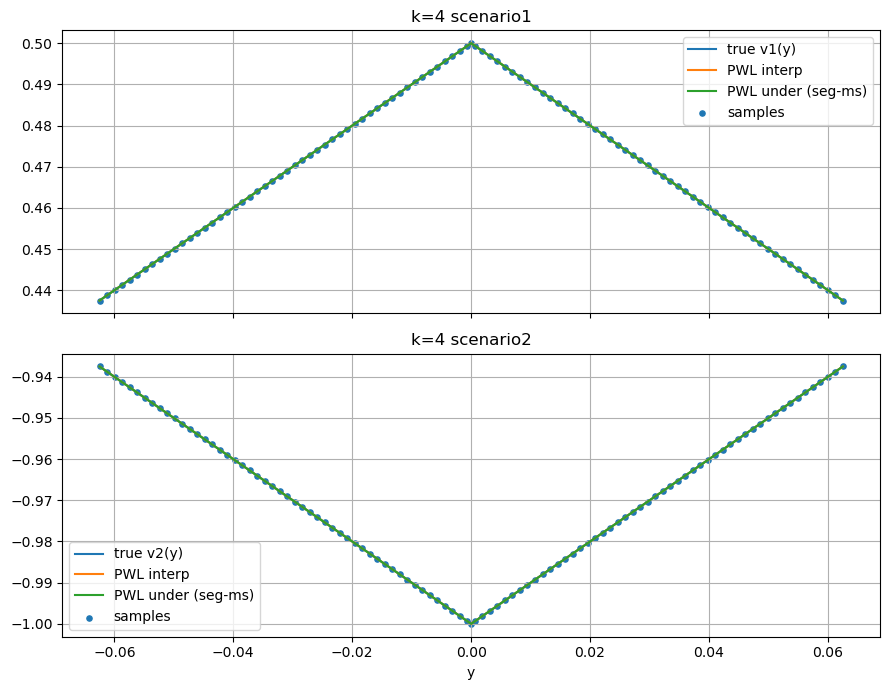

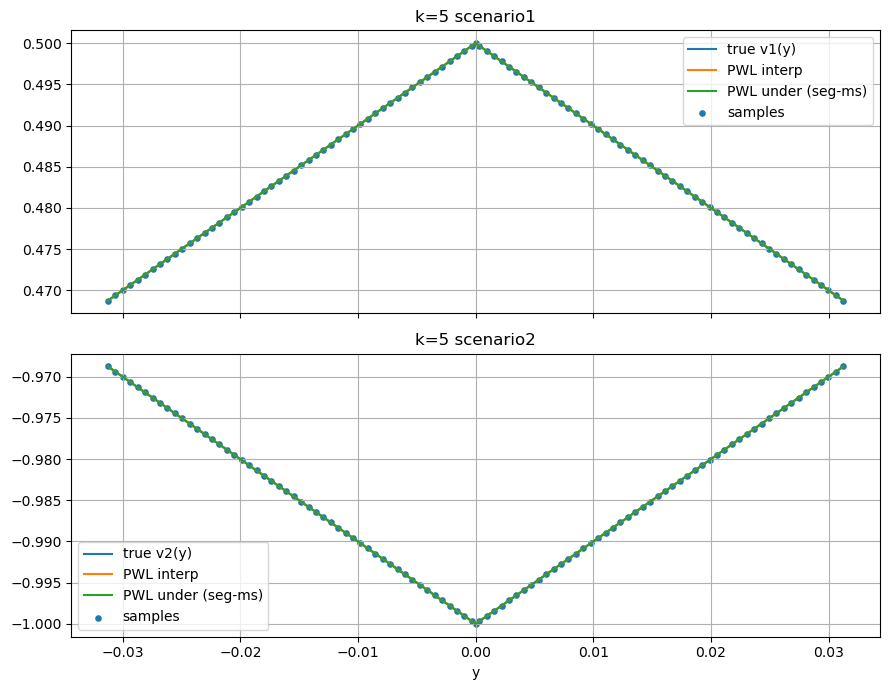

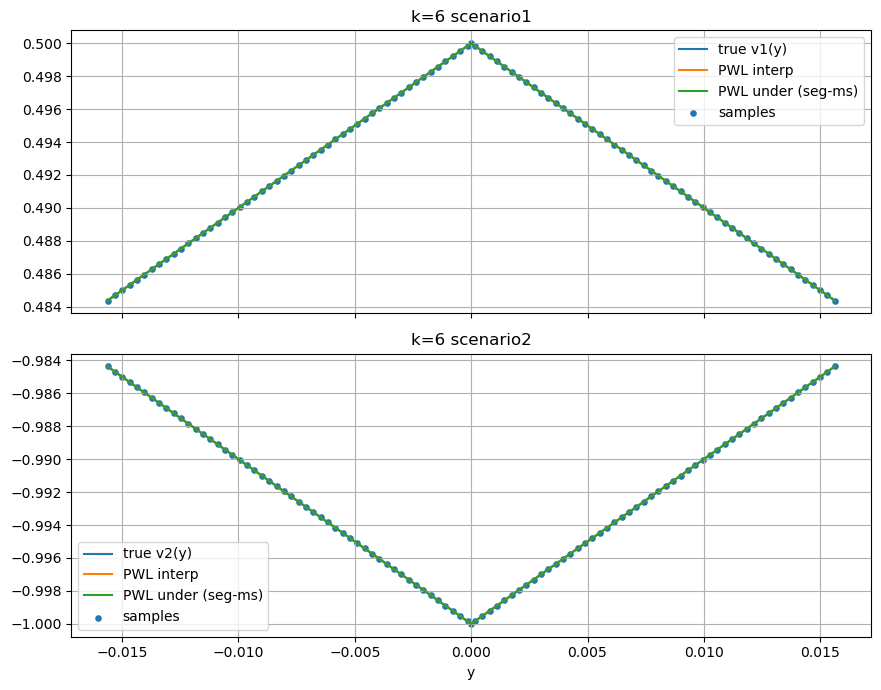

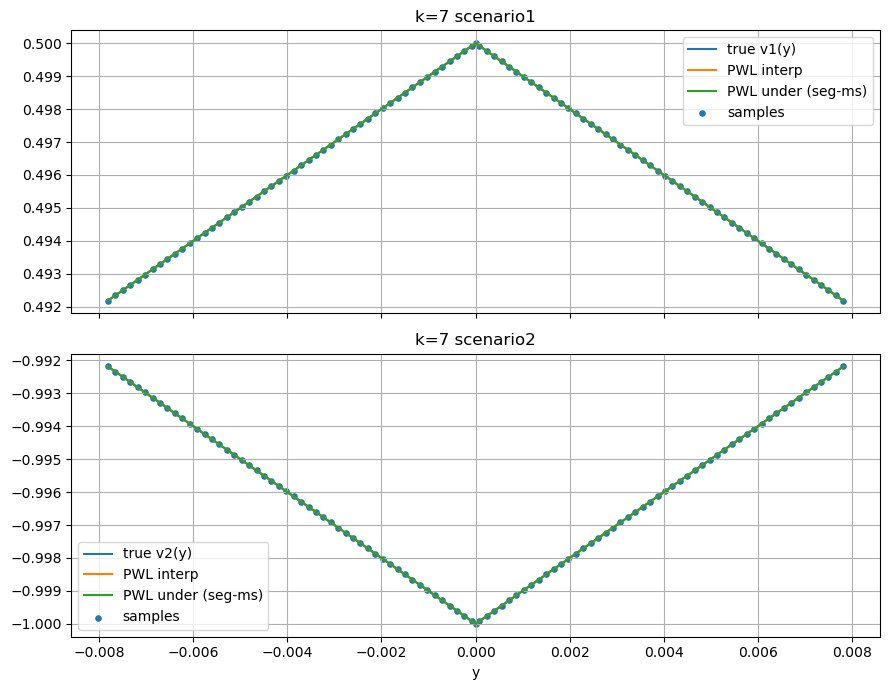

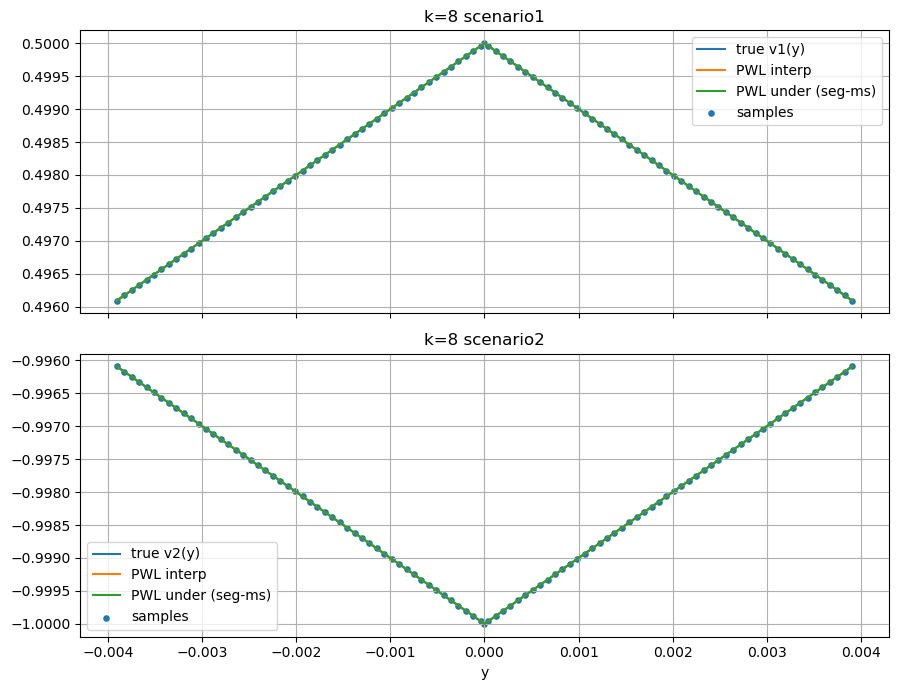

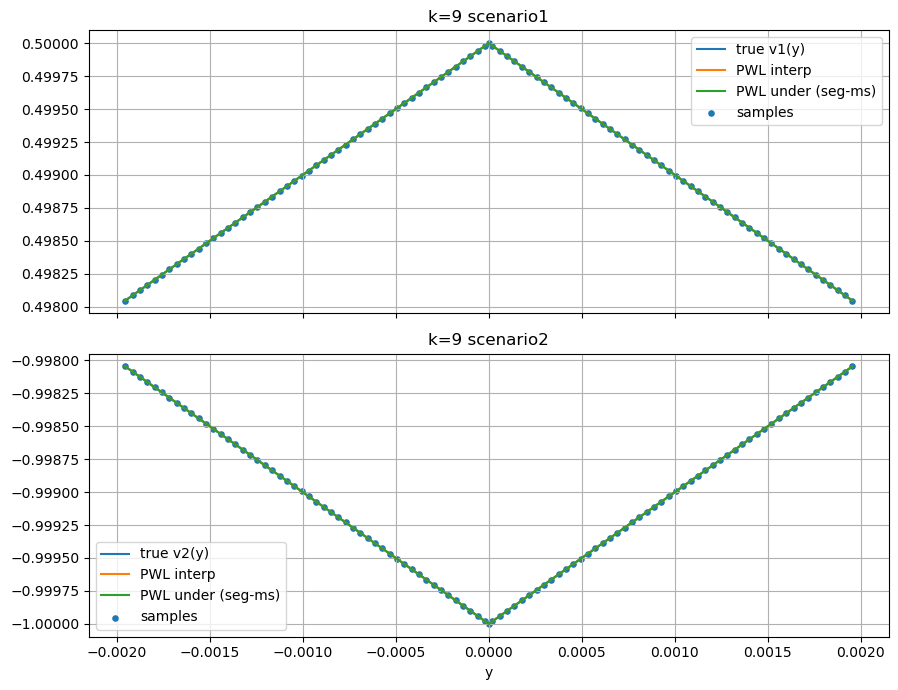

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Dict

# ============================================================
# P2 scenarios (paper)
# v1(y) = -|y| + 0.5
# v2(y) =  |y| - 1.0
# total v(y) = v1 + v2 = -0.5 (constant)
# ============================================================
def v1(y: float) -> float:
    return -abs(y) + 0.5

def v2(y: float) -> float:
    return abs(y) - 1.0

TRUE_MIN = -0.5  # min over any interval because v1+v2 is constant
YSTAR = 0.0

# IMPORTANT: total = sum (weights 1,1), consistent with your P2 code
P1 = 1.0
P2 = 1.0

# ============================================================
# Sampling
# ============================================================
def sample_points(Y: Tuple[float,float], n_samples: int, rng: np.random.Generator, mode: str) -> np.ndarray:
    lo, hi = Y
    if mode == "grid":
        ys = np.linspace(lo, hi, n_samples)
    elif mode == "random":
        ys = rng.uniform(lo, hi, size=n_samples)
    else:
        raise ValueError("mode must be 'grid' or 'random'")
    # ensure endpoints & 0 included
    ys = np.unique(np.concatenate([ys, np.array([lo, 0.0, hi])]))
    ys.sort()
    return ys

# ============================================================
# Piecewise linear interpolant + per-segment ms shifts
# ============================================================
@dataclass
class PWLSegment:
    xL: float
    xU: float
    slope: float
    intercept: float
    ms: float
    def line(self, x):
        x = np.asarray(x, dtype=float)
        return self.slope*x + self.intercept
    def under(self, x):
        return self.line(x) + self.ms

@dataclass
class PWLModel:
    xs: np.ndarray
    fs: np.ndarray
    segs: list

    def interp(self, x):
        x = np.asarray(x, dtype=float)
        y = np.empty_like(x)
        for i, xi in enumerate(x):
            y[i] = self._interp_scalar(float(xi))
        return y

    def under(self, x):
        x = np.asarray(x, dtype=float)
        y = np.empty_like(x)
        for i, xi in enumerate(x):
            y[i] = self._under_scalar(float(xi))
        return y

    def _find_seg_index(self, xi: float) -> int:
        i = int(np.searchsorted(self.xs, xi) - 1)
        if i < 0: i = 0
        if i >= len(self.xs)-1: i = len(self.xs)-2
        return i

    def _interp_scalar(self, xi: float) -> float:
        seg = self.segs[self._find_seg_index(xi)]
        return float(seg.line(xi))

    def _under_scalar(self, xi: float) -> float:
        seg = self.segs[self._find_seg_index(xi)]
        return float(seg.under(xi))

def segment_ms_by_grid(v: Callable[[float], float],
                       xL: float, xU: float,
                       slope: float, intercept: float,
                       n_grid: int = 2001) -> Tuple[float,float]:
    """
    ms = min_{x in [xL,xU]} (v(x) - (slope*x+intercept))
    Return (ms, argmin_x)
    """
    xs = np.linspace(xL, xU, n_grid)
    vx = np.array([v(float(t)) for t in xs])
    lx = slope*xs + intercept
    diff = vx - lx
    j = int(np.argmin(diff))
    return float(diff[j]), float(xs[j])

def build_pwl_underestimator(v: Callable[[float], float],
                             xs: np.ndarray,
                             ms_grid: int = 2001) -> Tuple[PWLModel, Dict]:
    xs = np.asarray(xs, dtype=float).ravel()
    xs = np.unique(xs)
    xs.sort()
    fs = np.array([v(float(t)) for t in xs], dtype=float)

    segs = []
    ms_list = []
    xms_list = []

    for i in range(len(xs)-1):
        xL, xU = float(xs[i]), float(xs[i+1])
        fL, fU = float(fs[i]), float(fs[i+1])
        if abs(xU - xL) < 1e-15:
            continue
        slope = (fU - fL) / (xU - xL)
        intercept = fL - slope*xL

        ms, x_arg = segment_ms_by_grid(v, xL, xU, slope, intercept, n_grid=ms_grid)
        segs.append(PWLSegment(xL=xL, xU=xU, slope=slope, intercept=intercept, ms=ms))
        ms_list.append(ms)
        xms_list.append(x_arg)

    model = PWLModel(xs=xs, fs=fs, segs=segs)
    diag = {"ms_per_segment": np.array(ms_list), "x_ms_per_segment": np.array(xms_list)}
    return model, diag

# ============================================================
# Hausdorff error on interval for P2:
# true min is -0.5, so err = (-0.5) - min(relax)
# Use dense grid to compute min (relax is piecewise linear).
# ============================================================
def hausdorff_error_for_interval_grid(Y: Tuple[float,float],
                                      m1: PWLModel,
                                      m2: PWLModel,
                                      n_grid: int = 20001) -> Tuple[float,float,float]:
    lo, hi = Y
    xs = np.linspace(lo, hi, n_grid)
    relax = P1*m1.under(xs) + P2*m2.under(xs)
    j = int(np.argmin(relax))
    lb = float(relax[j])
    err = TRUE_MIN - lb
    return lb, err, float(xs[j])

# ============================================================
# Experiment runner + plots
# ============================================================
def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x > 0) & (y > 0)
    x = x[mask]; y = y[mask]
    if x.size < 2:
        return float("nan")
    beta, _ = np.polyfit(np.log(x), np.log(y), 1)
    return float(beta)

def run_p2_pwl_experiment(
    sampling: str = "grid",
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 10,
    n_samples: int = 100,
    seed: int = 1,
    ms_grid: int = 2001,
    lb_grid: int = 20001
) -> Dict[str, object]:
    rng = np.random.default_rng(seed)

    diam_list, err_list, lb_list = [], [], []
    rounds = []

    for k in range(n_levels):
        eps = eps0*(rho**k)
        Y = (YSTAR - eps, YSTAR + eps)

        xs = sample_points(Y, n_samples=n_samples, rng=rng, mode=sampling)

        m1, d1 = build_pwl_underestimator(v1, xs, ms_grid=ms_grid)
        m2, d2 = build_pwl_underestimator(v2, xs, ms_grid=ms_grid)

        lb, err, y_argmin = hausdorff_error_for_interval_grid(Y, m1, m2, n_grid=lb_grid)

        diam_list.append(2*eps)
        err_list.append(err)
        lb_list.append(lb)

        rounds.append(dict(k=k, Y=Y, xs=xs, m1=m1, m2=m2, d1=d1, d2=d2, lb=lb, err=err, y_argmin=y_argmin))

    return dict(
        diam=np.array(diam_list),
        err=np.array(err_list),
        lb=np.array(lb_list),
        rounds=rounds,
        params=dict(sampling=sampling, eps0=eps0, rho=rho, n_levels=n_levels, n_samples=n_samples, seed=seed)
    )

def plot_convergence(out: Dict[str, object], slope_fit_last: int = 6) -> float:
    diam = out["diam"]
    err  = out["err"]
    mask = (diam > 0) & (err > 0)
    d2 = diam[mask]; e2 = err[mask]

    if d2.size < 2:
        print("Not enough positive error points to fit slope (errors may be ~0).")
        plt.figure(figsize=(6,4))
        plt.plot(diam, err, marker="o")
        plt.title("P2 error (linear scale)")
        plt.xlabel("diam(Y)")
        plt.ylabel("Hausdorff error")
        plt.grid(True)
        plt.show()
        return float("nan")

    K = min(slope_fit_last, d2.size)
    beta = estimate_slope_loglog(d2[-K:], e2[-K:])

    lx = np.log(d2[-K:])
    ly = np.log(e2[-K:])
    c = float(np.mean(ly - beta*lx))
    fit = np.exp(beta*np.log(d2) + c)

    plt.figure(figsize=(7,5))
    plt.loglog(d2, e2, marker="o", linestyle="-", label="Hausdorff error")
    plt.loglog(d2, fit, linestyle="--", label=f"fit last {K}, beta={beta:.3f}")
    p = out["params"]
    plt.title(f"P2 PWL segment-ms, sampling={p['sampling']}, n_samples={p['n_samples']}")
    plt.xlabel("diam(Y)")
    plt.ylabel("Hausdorff error")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()
    return beta

def plot_round(round_info: Dict[str, object], n_grid: int = 1200):
    k = round_info["k"]
    lo, hi = round_info["Y"]
    xs = round_info["xs"]
    m1, m2 = round_info["m1"], round_info["m2"]

    grid = np.linspace(lo, hi, n_grid)

    fig, axes = plt.subplots(2,1,sharex=True,figsize=(9,7))

    ax = axes[0]
    ax.plot(grid, [v1(float(t)) for t in grid], label="true v1(y)")
    ax.plot(grid, m1.interp(grid), label="PWL interp")
    ax.plot(grid, m1.under(grid), label="PWL under (seg-ms)")
    ax.scatter(xs, [v1(float(t)) for t in xs], s=14, label="samples")
    ax.grid(True)
    ax.set_title(f"k={k} scenario1")
    ax.legend()

    ax = axes[1]
    ax.plot(grid, [v2(float(t)) for t in grid], label="true v2(y)")
    ax.plot(grid, m2.interp(grid), label="PWL interp")
    ax.plot(grid, m2.under(grid), label="PWL under (seg-ms)")
    ax.scatter(xs, [v2(float(t)) for t in xs], s=14, label="samples")
    ax.grid(True)
    ax.set_title(f"k={k} scenario2")
    ax.legend()

    axes[1].set_xlabel("y")
    fig.tight_layout()
    plt.show()

# ============================================================
# RUN (edit here)
# ============================================================
params = dict(
    sampling="grid",  # "grid" or "random"
    eps0=1.0,
    rho=0.5,
    n_levels=10,
    n_samples=100,
    seed=1,
    ms_grid=2001,
    lb_grid=20001,
)

out = run_p2_pwl_experiment(**params)
beta = plot_convergence(out, slope_fit_last=6)
print("Estimated beta =", beta)

for r in out["rounds"]:
    plot_round(r, n_grid=1400)
